# 5. Asign taxonomy to nanopore reads

In [6]:
library(tidyverse) 
library(dplyr)
library(ggplot2)
library(ggpubr)
library(GenomicAlignments)

In [7]:
print("Working directory before:")
getwd()

setwd("/home/strawberry/Documents/Collaborations/sinusite_edwin/data") # changing work directory to data 
print("Working directory after:")
getwd()

[1] "Working directory before:"


[1] "/home/strawberry/Documents/Collaborations/sinusite_edwin/data"

[1] "Working directory after:"


[1] "/home/strawberry/Documents/Collaborations/sinusite_edwin/data"

In [35]:
# Loading reference file (linking refseq accession number and taxID) - this file was obtained parsing gff3 file provided by NCBI 
RefseqTaxID <- read.delim("./RefseqTaxID.txt", h=T)
head(RefseqTaxID)
# SILVATaxID <- read.csv("./silva_taxonomy.csv", h=T)
# SILVATaxID$id <- gsub("\\..*", "", SILVATaxID$id) # Clean the 'id' column (remove everything after the first dot)
# head(SILVATaxID)

# Loading TaxID full lineage file - no need for SILVA db, already contains id linked to full taxonomy in the above df 
TaxID_FullLineage <- read.delim("./referencetable_taxonomy_RefseqNCBI_16S.txt", quote = "")
head(TaxID_FullLineage)

# Loading metadata file including read counts after quality check
metadata_full_clean <- read.delim("./metadata_full_clean.tsv", h=T) 
head(metadata_full_clean)

,Refseq,TaxID
,<chr>,<int>
1,NR_189271.1,2668075
2,NR_189270.1,3049108
3,NR_189269.1,3048013
4,NR_189268.1,3048010
5,NR_189267.1,2795386
6,NR_189266.1,3018743


,id,name,Species,Genus,Family,Order,Class,Phylum,Kingdom,Domain
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2,Bacteria,NA,NA,NA,NA,NA,NA,NA,NA
2,57723,Acidobacteriota,NA,NA,NA,NA,NA,NA,NA,Bacteria
3,1562566,Blastocatellia,NA,NA,NA,NA,NA,Acidobacteriota,NA,Bacteria
4,1748771,Blastocatellales,NA,NA,NA,NA,Blastocatellia,Acidobacteriota,NA,Bacteria
5,3069972,Arenimicrobiaceae,NA,NA,NA,Blastocatellales,Blastocatellia,Acidobacteriota,NA,Bacteria
6,2048907,Arenimicrobium,NA,NA,Arenimicrobiaceae,Blastocatellales,Blastocatellia,Acidobacteriota,NA,Bacteria


,ID_Sample,SNOT22,SNOT22nasal,LK_Total,LK_Secret,ClinicCtrl,AntUse,Cortuse,Patient,Filename,⋯,Timepoint,Sex,Age,Atopic_Symptoms,Asthma,NSAID_Intolerance,Total_IgE,Blood_Eosinophilia,Tissue_Eosinophilia,Final_LundMackay
,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<chr>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>
1,0001967K_T1,38,12,4,2,NC,1,1,0001967K,0001967K_T1.fastq,⋯,T1,1,58.7,1,1,0,38,100,10,15
2,0001967K_T3,96,26,10,4,NC,1,0,0001967K,0001967K_T3.fastq,⋯,T3,1,58.7,1,1,0,38,100,10,15
3,0001967K_T6,79,19,6,4,NC,1,1,0001967K,0001967K_T6.fastq,⋯,T6,1,58.7,1,1,0,38,100,10,15
4,0088303G_T0,102,37,8,2,NC,NA,0,0088303G,0088303G_T0.fastq,⋯,T0,2,60.3,1,1,0,667,800,58,22
5,0088303G_T1,32,7,4,1,NC,1,0,0088303G,0088303G_T1.fastq,⋯,T1,2,60.3,1,1,0,667,800,58,22
6,0088303G_T3,NA,NA,NA,NA,NA,0,0,0088303G,0088303G_T3.fastq,⋯,T3,2,60.3,1,1,0,667,800,58,22


In [43]:
# Initialize an empty dataframe for final results
dfall <- NULL

# List of Minimap2 output files (SAM format)
bam_files <- list.files(path = ".", pattern = "*.bam$", full.names = TRUE)
print(head(bam_files))

[1] "./0001967K_T1.bam" "./0001967K_T3.bam" "./0001967K_T6.bam"
[4] "./0018303G_T0.bam" "./0088303G_T0.bam" "./0088303G_T1.bam"


In [45]:
# Process each BAM file
for (file in bam_files) {
#     cat("\nProcessing file:", file, "\n")
 # file = "0689227I_T12.bam"
    # Read BAM file into GenomicAlignments object
    aln <- readGAlignments(file, use.names = TRUE)
# head(aln)
    # Extract reference sequences (i.e., aligned database sequences)
    seqnames <- as.character(seqnames(aln))  # Extract the 'seqnames' from the GAlignments object
    refseq_ids <- gsub("^.*(NR.*)", "\\1", seqnames)
    freqtab <- table(refseq_ids)
# print(freqtab)
    # Create a dataframe with RefSeq and read counts
    df <- data.frame(Refseq = names(freqtab), Counts = as.numeric(freqtab))
# print(df)
    # Merge with TaxID_FullLineage for taxonomic classification
    freqtable_tax <- merge(dfTaxID, TaxID_FullLineage, by.x = "TaxID", by.y = "id", all.x = TRUE)
# head(freqtable_tax)
    # Extract sample ID from filename
    freqtable_tax$ID_Sample <- gsub(".bam", "", basename(file))
# head(freqtable_tax)
    # Merge with metadata
    freqtable_tax_metadata <- merge(freqtable_tax, metadata_full_clean, by = "ID_Sample", all.x = TRUE)
# head(freqtable_tax_metadata)
    # Calculate relative abundance
    freqtable_tax_metadata <- freqtable_tax_metadata %>%
        group_by(ID_Sample) %>%
        mutate(RelativeAbundance = (Counts / sum(Counts)) * 100)
# head(freqtable_tax_metadata)
    # Calculate alignment efficiency
    freqtable_tax_metadata <- freqtable_tax_metadata %>%
        group_by(ID_Sample) %>%
        mutate(AlignmentEffic = (sum(Counts) / nreads) * 100)
# head(freqtable_tax_metadata)

        # Append results to final dataframe
    dfall <- bind_rows(dfall, freqtable_tax_metadata)
}

# A tibble: 6 × 35
# Groups:   ID_Sample [1]
  ID_Sample   TaxID Refseq  Counts name  Species Genus Family Order Class Phylum
  <chr>       <int> <chr>    <dbl> <chr> <chr>   <chr> <chr>  <chr> <chr> <chr> 
1 0001967K_T1   545 NR_117…      2 Citr… Citrob… Citr… Enter… Ente… Gamm… Pseud…
2 0001967K_T1   573 NR_117…      2 Kleb… Klebsi… Kleb… Enter… Ente… Gamm… Pseud…
3 0001967K_T1  1260 NR_041…      4 Fine… Finego… Fine… Pepto… Tiss… Tiss… Bacil…
4 0001967K_T1  1280 NR_036…      4 Stap… Staphy… Stap… Staph… Baci… Baci… Bacil…
5 0001967K_T1  1280 NR_115…      8 Stap… Staphy… Stap… Staph… Baci… Baci… Bacil…
6 0001967K_T1  1282 NR_036…    144 Stap… Staphy… Stap… Staph… Baci… Baci… Bacil…
# ℹ 24 more variables: Kingdom <chr>, Domain <chr>, SNOT22 <int>,
#   SNOT22nasal <int>, LK_Total <int>, LK_Secret <int>, ClinicCtrl <chr>,
#   AntUse <int>, Cortuse <int>, Patient <chr>, Filename <chr>, nreads <int>,
#   Timepoint <chr>, Sex <int>, Age <dbl>, Atopic_Symptoms <int>, Asthma <int>,
#   NSAID

In [46]:
head(dfall)

ID_Sample,TaxID,Refseq,Counts,name,Species,Genus,Family,Order,Class,⋯,Age,Atopic_Symptoms,Asthma,NSAID_Intolerance,Total_IgE,Blood_Eosinophilia,Tissue_Eosinophilia,Final_LundMackay,RelativeAbundance,AlignmentEffic
<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
0001967K_T1,545,NR_117751.1,2,Citrobacter koseri,Citrobacter koseri,Citrobacter,Enterobacteriaceae,Enterobacterales,Gammaproteobacteria,⋯,58.7,1,1,0,38,100,10,15,0.621118,32.26453
0001967K_T1,573,NR_117683.1,2,Klebsiella pneumoniae,Klebsiella pneumoniae,Klebsiella,Enterobacteriaceae,Enterobacterales,Gammaproteobacteria,⋯,58.7,1,1,0,38,100,10,15,0.621118,32.26453
0001967K_T1,1260,NR_041935.1,4,Finegoldia magna,Finegoldia magna,Finegoldia,Peptoniphilaceae,Tissierellales,Tissierellia,⋯,58.7,1,1,0,38,100,10,15,1.242236,32.26453
0001967K_T1,1280,NR_036828.1,4,Staphylococcus aureus,Staphylococcus aureus,Staphylococcus,Staphylococcaceae,Bacillales,Bacilli,⋯,58.7,1,1,0,38,100,10,15,1.242236,32.26453
0001967K_T1,1280,NR_115606.1,8,Staphylococcus aureus,Staphylococcus aureus,Staphylococcus,Staphylococcaceae,Bacillales,Bacilli,⋯,58.7,1,1,0,38,100,10,15,2.484472,32.26453
0001967K_T1,1282,NR_036904.1,144,Staphylococcus epidermidis,Staphylococcus epidermidis,Staphylococcus,Staphylococcaceae,Bacillales,Bacilli,⋯,58.7,1,1,0,38,100,10,15,44.720497,32.26453


In [49]:
write.table(dfall, file = "./taxonomy_results_minimap2.tsv", sep = "\t", row.names = FALSE, quote = FALSE)

In [47]:
print("Relative Abundance:")
print(summary(dfall$RelativeAbundance))

print("Alignment Efficency:")
print(summary(dfall$AlignmentEffic))

[1] "Relative Abundance:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3106  0.6211  1.2422  3.5084  1.8634 44.7205 
[1] "Alignment Efficency:"
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
   0.5564    3.7429    6.7870   45.5293   17.1095 1894.1176       336 


In [48]:
# Calculate annotation frequency
## I.e. - percentage of reads that were annotated using that database

## Calculate mean and SD of frequence aligment by group

summary_stats_patient <- dfall %>%
  group_by(Patient) %>%
  summarise(mean_AlignmentEffic = mean(AlignmentEffic, na.rm = TRUE),
            sd_AlignmentEffic = sd(AlignmentEffic, na.rm = TRUE))
print(summary_stats_patient) 

summary_stats_timepoint <- dfall %>%
  group_by(Timepoint) %>%
  summarise(mean_AlignmentEffic = mean(AlignmentEffic, na.rm = TRUE),
            sd_AlignmentEffic = sd(AlignmentEffic, na.rm = TRUE))
print(summary_stats_timepoint) 

#write.table(summary_stats_patient, file = "freqalignment_patient.tsv", sep = "\t", row.names = FALSE)

# A tibble: 42 × 3
   Patient  mean_AlignmentEffic sd_AlignmentEffic
   <chr>                  <dbl>             <dbl>
 1 0001967K               11.7              14.6 
 2 0088303G                5.86              3.15
 3 0110059G              121.              161.  
 4 0130765A               16.6              15.6 
 5 0207720E                9.13              7.44
 6 0236549G               23.6              24.7 
 7 0313863D                3.55              1.08
 8 0332596H              192.              188.  
 9 0492882D               30.6              50.6 
10 0514164A              476.              822.  
# ℹ 32 more rows
# A tibble: 6 × 3
  Timepoint mean_AlignmentEffic sd_AlignmentEffic
  <chr>                   <dbl>             <dbl>
1 T0                       6.16              5.29
2 T1                      27.0              78.6 
3 T12                     53.7              70.2 
4 T3                      42.4             121.  
5 T6                     111.              343

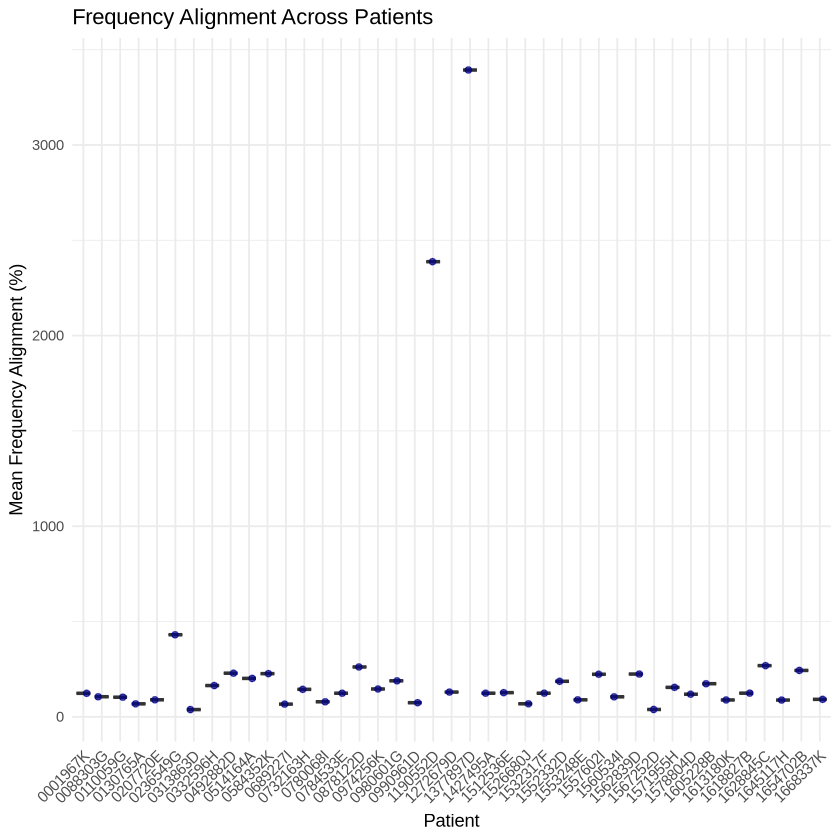

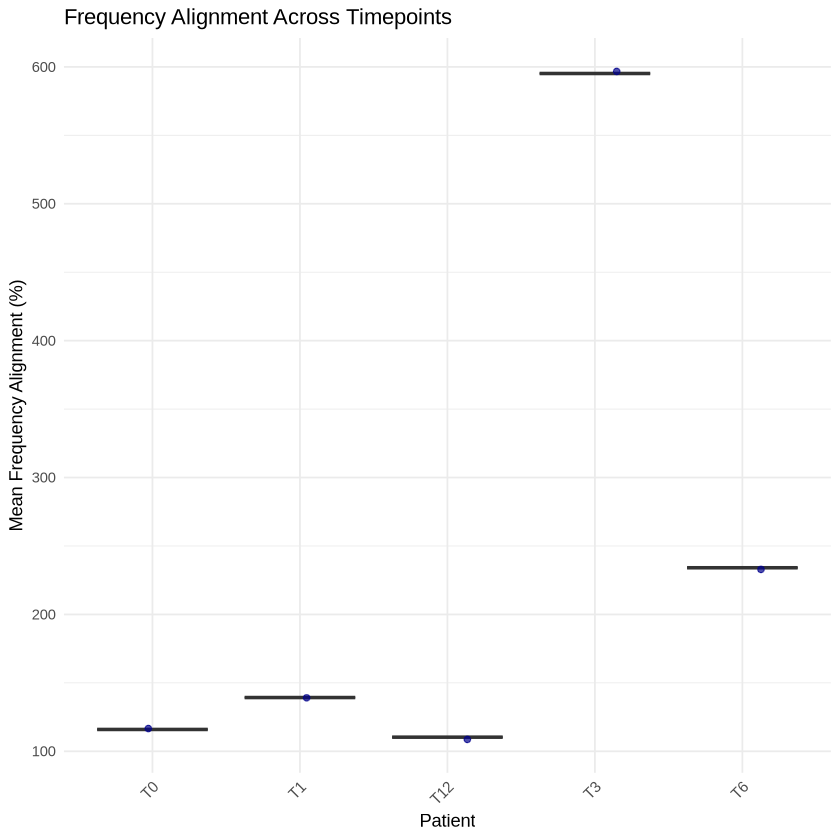

In [20]:
# Plot the frequence alignment distribution across groups
freqalignment_A <- ggplot(summary_stats_patient, aes(x = Patient, y = mean_AlignmentEffic)) +
  geom_boxplot(fill = "skyblue", alpha = 0.6) +
  geom_jitter(width = 0.2, color = "darkblue", alpha = 0.7) +
  theme_minimal() +
  labs(title = "Frequency Alignment Across Patients",
       x = "Patient", y = "Mean Frequency Alignment (%)") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
freqalignment_A

freqalignment_B <- ggplot(summary_stats_timepoint, aes(x = Timepoint, y = mean_AlignmentEffic)) +
  geom_boxplot(fill = "skyblue", alpha = 0.6) +
  geom_jitter(width = 0.2, color = "darkblue", alpha = 0.7) +
  theme_minimal() +
  labs(title = "Frequency Alignment Across Timepoints",
       x = "Patient", y = "Mean Frequency Alignment (%)") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
freqalignment_B

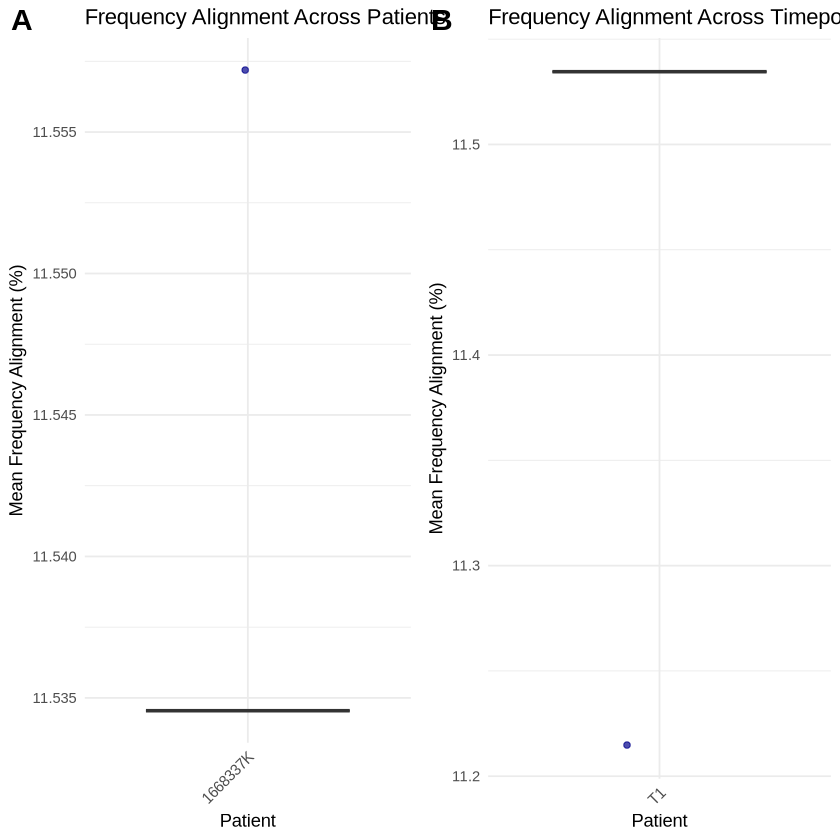

In [86]:
## Arrange plots
freqalignment_groups <- ggarrange(freqalignment_A, freqalignment_B, 
          labels = c("A", "B"),
          font.label = list(size = 18),
          ncol = 2, nrow = 1) # this will couple the plots, arranging them (in this case) in 2 columns and 1 row 
freqalignment_groups